<a href="https://colab.research.google.com/github/rithikkulkarni/Video-Virality-Testing/blob/main/rf_pipeline_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
# Setup & load
import pandas as pd
import numpy as np

filepath = "/content/group6_extracted.csv"  # <- change if needed
df = pd.read_csv(filepath)

print("Shape:", df.shape)
print("Columns:", len(df.columns))

# Target
TARGET_COL = "viral_label"
if TARGET_COL not in df.columns:
    raise KeyError(f"Missing target column '{TARGET_COL}' in CSV.")

# Basic hygiene
df = df.replace([np.inf, -np.inf], np.nan)

# Keep only numeric features for the RF (drop text/path columns automatically)
non_feature_cols = {"title", "tags", "thumbnail_path"}  # anything clearly non-numeric
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
# ensure target is last and not in features
feature_cols = [c for c in numeric_cols if c != TARGET_COL]

print("Numeric feature count:", len(feature_cols))
print("Positive rate (viral=1):", df[TARGET_COL].mean().round(4))

Shape: (30529, 81)
Columns: 81
Numeric feature count: 80
Positive rate (viral=1): 0.151


In [8]:
# Utils: metrics + CV splitter + seeding
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import (
    roc_auc_score, average_precision_score, accuracy_score,
    precision_score, recall_score, f1_score, log_loss
)

RANDOM_STATE = 42
N_SPLITS = 10
cv = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=RANDOM_STATE)

def compute_metrics(y_true, proba):
    """Return a dict of metrics from true labels and predicted probabilities."""
    y_pred = (proba >= 0.5).astype(int)
    out = {}
    # If all labels the same, guard metrics
    try: out["AUC"] = roc_auc_score(y_true, proba)
    except: out["AUC"] = np.nan
    try: out["PR_AUC"] = average_precision_score(y_true, proba)
    except: out["PR_AUC"] = np.nan
    out["Accuracy"]  = accuracy_score(y_true, y_pred)
    out["Precision"] = precision_score(y_true, y_pred, zero_division=0)
    out["Recall"]    = recall_score(y_true, y_pred, zero_division=0)
    out["F1"]        = f1_score(y_true, y_pred, zero_division=0)
    try: out["LogLoss"] = log_loss(y_true, np.clip(proba, 1e-7, 1-1e-7))
    except: out["LogLoss"] = np.nan
    return out

def summarize_metric_rows(rows):
    dfm = pd.DataFrame(rows)
    return pd.DataFrame({
        "mean": dfm.mean(),
        "std": dfm.std(ddof=1)
    }).round(4)

In [9]:
# Random Forest CV
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier

X = df[feature_cols].copy()
y = df[TARGET_COL].astype(int).values
idx = df.index.to_numpy()

rf_oof = np.zeros(len(df), dtype=float)
rf_fold_metrics = []
rf_imps = []

rf_pipe = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("rf", RandomForestClassifier(
        n_estimators=400,
        max_depth=None,
        min_samples_split=5,
        min_samples_leaf=2,
        max_features="sqrt",
        bootstrap=True,
        max_samples=0.9,
        class_weight="balanced_subsample",
        n_jobs=-1,
        random_state=RANDOM_STATE
    ))
])

for fold, (tr, va) in enumerate(cv.split(X, y), 1):
    X_tr, X_va = X.iloc[tr], X.iloc[va]
    y_tr, y_va = y[tr], y[va]
    rf_pipe.fit(X_tr, y_tr)
    proba = rf_pipe.predict_proba(X_va)[:, 1]
    rf_oof[va] = proba
    rf_fold_metrics.append(compute_metrics(y_va, proba))
    # feature importances (aligned with feature_cols order)
    rf_imps.append(rf_pipe.named_steps["rf"].feature_importances_)

rf_report = summarize_metric_rows(rf_fold_metrics)
rf_importance = pd.Series(np.mean(rf_imps, axis=0), index=feature_cols).sort_values(ascending=False)

print("Random Forest 10-fold CV metrics:")
display(rf_report)

df["oof_rf_proba"] = rf_oof

Random Forest 10-fold CV metrics:


,mean,std
AUC,0.7858,0.0145
PR_AUC,0.4453,0.0152
Accuracy,0.8566,0.0015
Precision,0.8224,0.0631
Recall,0.0646,0.0068
F1,0.1198,0.0120
LogLoss,0.3668,0.0035


In [10]:
# XGBoost CV
!pip install -q xgboost
from xgboost import XGBClassifier
from sklearn.impute import SimpleImputer

xgb_oof = np.zeros(len(df), dtype=float)
xgb_fold_metrics = []
xgb_imps = []

# Using a solid, fast baseline
xgb_pipe = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("xgb", XGBClassifier(
        n_estimators=300,
        max_depth=6,
        learning_rate=0.05,
        subsample=0.8,
        colsample_bytree=0.8,
        reg_lambda=1.0,
        objective="binary:logistic",
        eval_metric="logloss",
        tree_method="hist",
        n_jobs=-1,
        random_state=RANDOM_STATE
    ))
])

for fold, (tr, va) in enumerate(cv.split(X, y), 1):
    X_tr, X_va = X.iloc[tr], X.iloc[va]
    y_tr, y_va = y[tr], y[va]
    xgb_pipe.fit(X_tr, y_tr)
    proba = xgb_pipe.predict_proba(X_va)[:, 1]
    xgb_oof[va] = proba
    xgb_fold_metrics.append(compute_metrics(y_va, proba))
    # Importances (gain) via booster; keys are f0,f1,... matching column order
    booster = xgb_pipe.named_steps["xgb"].get_booster()
    scores = booster.get_score(importance_type="gain")
    imp_vec = np.zeros(len(feature_cols), dtype=float)
    for k, v in scores.items():
        j = int(k[1:])  # 'f12' -> 12
        if 0 <= j < len(feature_cols):
            imp_vec[j] = v
    xgb_imps.append(imp_vec)

xgb_report = summarize_metric_rows(xgb_fold_metrics)
# Normalize gain importances per fold before averaging to reduce scale effects
xgb_imps = np.array([
    imp/imp.sum() if imp.sum() > 0 else imp
    for imp in xgb_imps
])
xgb_importance = pd.Series(xgb_imps.mean(axis=0), index=feature_cols).sort_values(ascending=False)

print("XGBoost 10-fold CV metrics:")
display(xgb_report)

df["oof_xgb_proba"] = xgb_oof

XGBoost 10-fold CV metrics:


,mean,std
AUC,0.7814,0.0129
PR_AUC,0.4441,0.0149
Accuracy,0.8603,0.0029
Precision,0.7323,0.0532
Recall,0.1174,0.0139
F1,0.2022,0.0221
LogLoss,0.3522,0.0052


In [11]:
# PyTorch GRU "RNN" over feature sequence (each feature is a timestep)
# NOTE: RNNs aren't ideal for unordered tabular data, but provided per request.
import torch, math
from torch import nn
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
EPOCHS = 12
BATCH = 256
LR = 1e-3

class GRUTabular(nn.Module):
    def __init__(self, seq_len):
        super().__init__()
        self.gru = nn.GRU(input_size=1, hidden_size=64, num_layers=1, batch_first=True)
        self.head = nn.Sequential(
            nn.Linear(64, 64), nn.ReLU(),
            nn.Linear(64, 1)
        )
    def forward(self, x):  # x: [B, L] -> reshape to [B, L, 1]
        x = x.unsqueeze(-1)
        out, _ = self.gru(x)
        h = out[:, -1, :]
        logits = self.head(h)
        return logits.squeeze(-1)

def train_epoch(model, loader, criterion, opt):
    model.train()
    total = 0.0
    for xb, yb in loader:
        xb, yb = xb.to(DEVICE), yb.to(DEVICE)
        opt.zero_grad()
        logits = model(xb)
        loss = criterion(logits, yb.float())
        loss.backward()
        opt.step()
        total += loss.item() * xb.size(0)
    return total / max(1, len(loader.dataset))

@torch.no_grad()
def pred_proba(model, X):
    model.eval()
    probs = []
    for i in range(0, X.shape[0], 4096):
        xb = torch.tensor(X[i:i+4096], dtype=torch.float32, device=DEVICE)
        logits = model(xb)
        probs.append(torch.sigmoid(logits).detach().cpu().numpy())
    return np.concatenate(probs, axis=0)

rnn_oof = np.zeros(len(df), dtype=float)
rnn_fold_metrics = []
rnn_perm_importance = None  # compute on first fold for speed

for fold, (tr, va) in enumerate(cv.split(X, y), 1):
    X_tr, X_va = X.iloc[tr].copy(), X.iloc[va].copy()
    y_tr, y_va = y[tr], y[va]

    # Impute + scale (fit on train only)
    imp = SimpleImputer(strategy="median")
    scl = StandardScaler(with_mean=True, with_std=True)
    X_tr_np = scl.fit_transform(imp.fit_transform(X_tr))
    X_va_np = scl.transform(imp.transform(X_va))

    model = GRUTabular(seq_len=X_tr_np.shape[1]).to(DEVICE)
    opt = torch.optim.Adam(model.parameters(), lr=LR, weight_decay=1e-5)
    criterion = nn.BCEWithLogitsLoss()

    ds_tr = TensorDataset(torch.tensor(X_tr_np, dtype=torch.float32),
                          torch.tensor(y_tr, dtype=torch.float32))
    dl_tr = DataLoader(ds_tr, batch_size=BATCH, shuffle=True, drop_last=False)

    # Train
    best_loss, patience, no_improve = math.inf, 3, 0
    for epoch in range(1, EPOCHS+1):
        tr_loss = train_epoch(model, dl_tr, criterion, opt)
        # simple early stopping on train loss (ok for small model)
        if tr_loss + 1e-4 < best_loss:
            best_loss = tr_loss
            no_improve = 0
            best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}
        else:
            no_improve += 1
            if no_improve >= patience:
                break

    # Load best
    if 'best_state' in locals():
        model.load_state_dict({k: v.to(DEVICE) for k, v in best_state.items()})

    # Predict OOF for this fold
    proba = pred_proba(model, X_va_np)
    rnn_oof[va] = proba
    rnn_fold_metrics.append(compute_metrics(y_va, proba))

    # Permutation importance on the first fold (fast, approximate)
    if rnn_perm_importance is None:
        base_auc = roc_auc_score(y_va, proba) if len(np.unique(y_va))>1 else np.nan
        drops = np.zeros(X_va_np.shape[1], dtype=float)
        rng = np.random.default_rng(RANDOM_STATE)
        # Subsample for speed if validation is big
        sub_idx = np.arange(len(y_va))
        if len(sub_idx) > 2000:
            sub_idx = rng.choice(sub_idx, size=2000, replace=False)
        X_base = X_va_np[sub_idx].copy()
        y_base = y_va[sub_idx]
        base_auc_sub = roc_auc_score(y_base, pred_proba(model, X_base)) if len(np.unique(y_base))>1 else np.nan
        for j in range(X_base.shape[1]):
            X_perm = X_base.copy()
            rng.shuffle(X_perm[:, j])
            proba_p = pred_proba(model, X_perm)
            try:
                auc_p = roc_auc_score(y_base, proba_p)
                drops[j] = max(0.0, base_auc_sub - auc_p)
            except:
                drops[j] = 0.0
        # Normalize to sum=1 for comparability
        if drops.sum() > 0:
            drops = drops / drops.sum()
        rnn_perm_importance = pd.Series(drops, index=feature_cols).sort_values(ascending=False)

print("RNN (GRU) 10-fold CV metrics:")
rnn_report = summarize_metric_rows(rnn_fold_metrics)
display(rnn_report)

df["oof_rnn_proba"] = rnn_oof

RNN (GRU) 10-fold CV metrics:


,mean,std
AUC,0.5811,0.0130
PR_AUC,0.2174,0.0119
Accuracy,0.8490,0.0000
Precision,0.0000,0.0000
Recall,0.0000,0.0000
F1,0.0000,0.0000
LogLoss,0.4175,0.0017


In [12]:
# Combine importances
imp_df = pd.DataFrame({
    "rf_importance": rf_importance,
    "xgb_importance": xgb_importance
}).fillna(0.0)

if rnn_perm_importance is not None:
    imp_df["rnn_perm_importance"] = rnn_perm_importance.reindex(imp_df.index).fillna(0.0)

# Normalize each column to sum=1 for comparability
for col in imp_df.columns:
    s = imp_df[col].sum()
    if s > 0:
        imp_df[col] = imp_df[col] / s

imp_df["avg_rank"] = imp_df.rank(ascending=False).mean(axis=1)
imp_df = imp_df.sort_values("avg_rank")

print("Top 20 features by average rank across models:")
display(imp_df.head(20).round(4))

Top 20 features by average rank across models:


,rf_importance,xgb_importance,rnn_perm_importance,avg_rank
tag_num_unique,0.0232,0.0250,0.0304,3.0000
trending_score,0.0179,0.0196,0.5380,3.6667
tag_multiword_ratio,0.0185,0.0188,0.0195,5.3333
title_emb_pca_14,0.0167,0.0183,0.0012,10.3333
title_emb_pca_07,0.0167,0.0145,0.0001,16.0000
title_emb_pca_17,0.0159,0.0132,0.0001,17.0000
title_emb_pca_06,0.0185,0.0267,0.0000,19.6667
title_emb_pca_16,0.0144,0.0129,0.0004,20.0000
title_emb_pca_15,0.0195,0.0182,0.0000,21.0000
tag_semantic_entropy,0.0196,0.0152,0.0000,22.0000


RF probability distribution summary:


,0
min,0.0000
p05,0.0608
p25,0.1158
median,0.1603
p75,0.2155
p95,0.3450
max,0.8986
mean,0.1764
std,0.0955



XGB probability distribution summary:


,0
min,0.0021
p05,0.0202
p25,0.0548
median,0.1003
p75,0.1794
p95,0.3869
max,0.9698
mean,0.1393
std,0.1295



RNN probability distribution summary:


,0
min,0.0436
p05,0.1033
p25,0.1274
median,0.1451
p75,0.1655
p95,0.2586
max,0.4977
mean,0.1548
std,0.0490


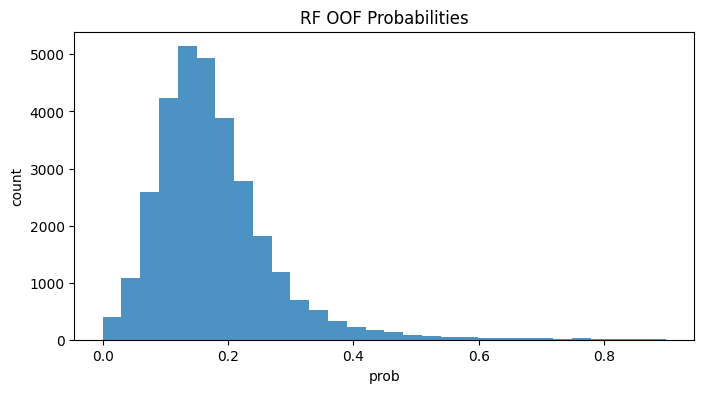

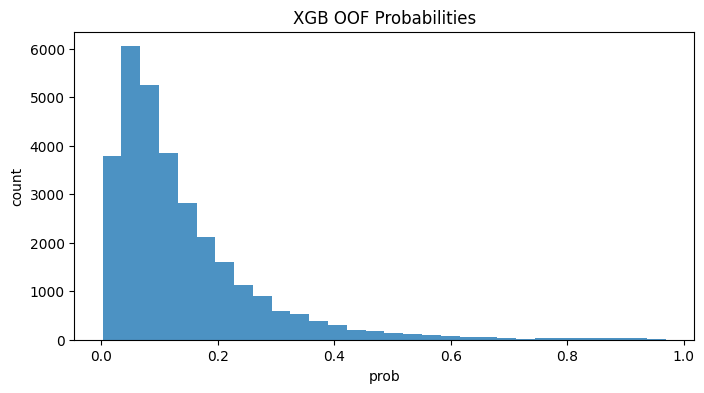

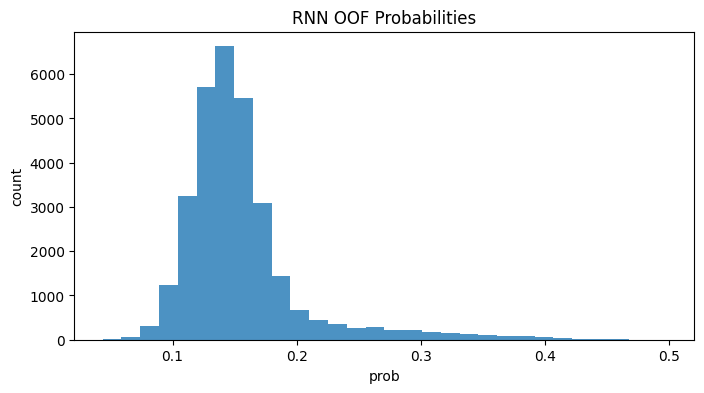

Score columns added (1–100): ['rf_score_1_100', 'xgb_score_1_100', 'rnn_score_1_100']


In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Simple summary of OOF proba distributions
def summarize_probs(name, p):
    s = pd.Series(p)
    out = {
        "min": s.min(), "p05": s.quantile(0.05), "p25": s.quantile(0.25),
        "median": s.median(), "p75": s.quantile(0.75), "p95": s.quantile(0.95), "max": s.max(),
        "mean": s.mean(), "std": s.std()
    }
    print(f"{name} probability distribution summary:")
    display(pd.Series(out).round(4))
    print()

summarize_probs("RF",  df["oof_rf_proba"].values)
summarize_probs("XGB", df["oof_xgb_proba"].values)
summarize_probs("RNN", df["oof_rnn_proba"].values)

# Optional histograms
plt.figure(figsize=(8,4)); plt.hist(df["oof_rf_proba"].dropna(), bins=30, alpha=0.8); plt.title("RF OOF Probabilities"); plt.xlabel("prob"); plt.ylabel("count"); plt.show()
plt.figure(figsize=(8,4)); plt.hist(df["oof_xgb_proba"].dropna(), bins=30, alpha=0.8); plt.title("XGB OOF Probabilities"); plt.xlabel("prob"); plt.ylabel("count"); plt.show()
plt.figure(figsize=(8,4)); plt.hist(df["oof_rnn_proba"].dropna(), bins=30, alpha=0.8); plt.title("RNN OOF Probabilities"); plt.xlabel("prob"); plt.ylabel("count"); plt.show()

# 1–100 scoring (linear scaling from prob 0..1)
for m in ["rf", "xgb", "rnn"]:
    col = f"oof_{m}_proba"
    if col in df.columns:
        df[f"{m}_score_1_100"] = (df[col].clip(0,1) * 99 + 1).round(0).astype("Int64")

print("Score columns added (1–100):", [c for c in df.columns if c.endswith("_score_1_100")])

In [14]:
# Side-by-side metrics
def row_of_means(report):
    return report["mean"].rename({"LogLoss":"LogLoss↓"}).to_frame().T

comparison = pd.concat([
    row_of_means(globals().get("rf_report")).assign(Model="RandomForest"),
    row_of_means(globals().get("xgb_report")).assign(Model="XGBoost"),
    row_of_means(globals().get("rnn_report")).assign(Model="RNN_GRU"),
], ignore_index=True).set_index("Model")[["AUC","PR_AUC","Accuracy","Precision","Recall","F1","LogLoss↓"]].round(4)

print("Model comparison (10-fold OOF):")
display(comparison)

Model comparison (10-fold OOF):


,AUC,PR_AUC,Accuracy,Precision,Recall,F1,LogLoss↓
Model,,,,,,,
RandomForest,0.7858,0.4453,0.8566,0.8224,0.0646,0.1198,0.3668
XGBoost,0.7814,0.4441,0.8603,0.7323,0.1174,0.2022,0.3522
RNN_GRU,0.5811,0.2174,0.8490,0.0000,0.0000,0.0000,0.4175
